In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from functools import partial
import pandas

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gerrychain

Note: you may need to restart the kernel to use updated packages.


In [4]:
graph = Graph.from_json("./final.json")

In [5]:
elections = [
    Election("LS25", {"BJP": "LS25BJP", "INC": "LS25INC","AAP": "LS25AAP"})
]

In [6]:
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOT_POP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [7]:
initial_partition = GeographicPartition(
    graph,
    assignment="INIT_DIST",
    updaters=my_updaters
)

In [8]:
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(
    recom,
    pop_col="TOT_POP",
    pop_target=ideal_population,
    epsilon=0.4,
    node_repeats=2
)

In [9]:
def cut_edges_length(p):
  return len(p["cut_edges"])

compactness_bound = constraints.UpperBound(
  cut_edges_length,
  2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.4)

In [67]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound,
        contiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from gerrychain import MarkovChain, accept
#from gerrychain import MarkovChain, accept
from gerrychain.constraints.contiguity import contiguous_components

# --- 0) LOAD YOUR PRECINCT GEOMETRIES ---
# Replace with your actual file path and ID column name:
gdf = gpd.read_file("/Users/ayush/Desktop/Project/Delhi_Shapefile/Delhi_AC.shp")
# Suppose your precincts have a unique field "PREC_ID" that matches
# the nodes in partition.assignment.  If it's already the index, skip this.
#gdf = gdf.set_index("id")

# --- 1) BUILD & RUN THE MARKOV CHAIN ---
# 1) compute initial discontinuity
initial_comps = contiguous_components(initial_partition)
# e.g. {district_id: [comp1_nodes, comp2_nodes, …], …}
initial_discont = sum(len(comps) - 1 for comps in initial_comps.values())

def max_initial_discontiguity(partition):
    """Return True if this map has ≤ initial_discont disconnected pieces per district."""
    comps = contiguous_components(partition)
    discont = sum(len(c) - 1 for c in comps.values())
    return discont <= initial_discont

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
        # max_initial_discontiguity
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

# --- 2) PREPARE A CONSISTENT COLOR MAP ---
initial_assign = initial_partition.assignment  # dict: node_id → district_id
district_ids = sorted(set(initial_assign.values()))
cmap = plt.cm.get_cmap("tab20", len(district_ids))
district_color = {d: cmap(i) for i, d in enumerate(district_ids)}

# --- 3) LOOP & PLOT EVERY 100th PLAN ---
for step, partition in enumerate(chain):
    if step % 100 == 0:
        # a) tag each precinct with its current district
        gdf_step = gdf.copy()
        gdf_step["district"] = gdf_step.index.to_series().map(partition.assignment)
        
        # b) dissolve into one polygon per district
        dissolved = gdf_step.dissolve(by="district")
        dissolved["color"] = dissolved.index.map(district_color)
        
        # c) plot shaded districts
        fig, ax = plt.subplots(figsize=(8, 6))
        dissolved.plot(
            ax=ax,
            color=dissolved["color"],
            edgecolor="black",
            linewidth=0.2
        )
        ax.set_title(f"Districting Map at Step {step}", fontsize=12)
        ax.set_axis_off()
        plt.tight_layout()
        
        # d) save to PNG
        fig.savefig(f"district_map_{step}.png", dpi=300)
        plt.close(fig)


/var/folders/k5/_b71wl5d5p561705617f8v500000gn/T/ipykernel_38511/3596371120.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(district_ids))


In [11]:
import tqdm
data = pandas.DataFrame(
    sorted(partition["LS25"].percents("BJP"))
    for partition in chain.with_progress_bar()
)

/usr/local/anaconda3/envs/delhi-map/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:02<00:00, 398.20it/s]


In [73]:
#pip install tqdm

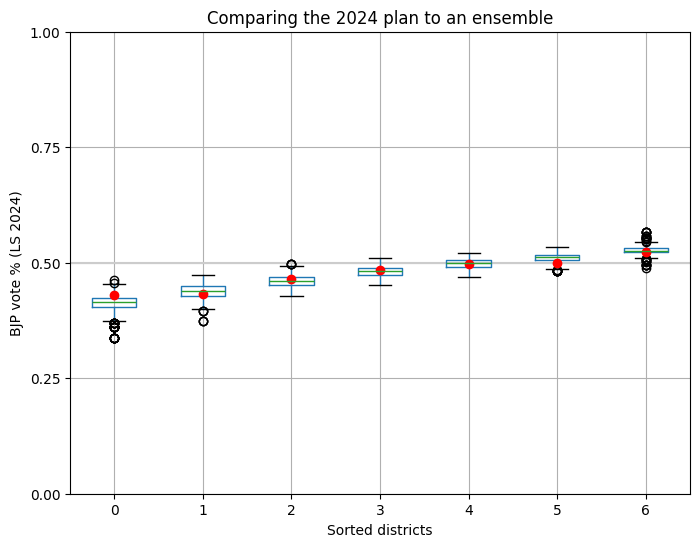

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
plt.plot(data.iloc[0], "ro")

# Annotat
ax.set_title("Comparing the 2024 plan to an ensemble")
ax.set_ylabel("BJP vote % (LS 2024)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()